<a href="https://colab.research.google.com/github/Muhammad-Al-Barbary/Diabetic-Retinopathy-Detection/blob/inceptionv3/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')



Mounted at /content/drive


In [19]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Flatten
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline 

In [4]:
batch_size = 32
img_height = 224
img_width = 224

data_dir = "/content/drive/MyDrive/Training Dataset"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


valid_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size )

print (train_ds.class_names)
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))

Found 3360 files belonging to 5 classes.
Using 2688 files for training.
Found 3360 files belonging to 5 classes.
Using 672 files for validation.
['0', '1', '2', '3', '4']


In [5]:
image_batch, labels_batch = next(iter(train_ds))
print("batch size:",image_batch.shape)
print("number of batches:",len(train_ds))

batch size: (32, 224, 224, 3)
number of batches: 84


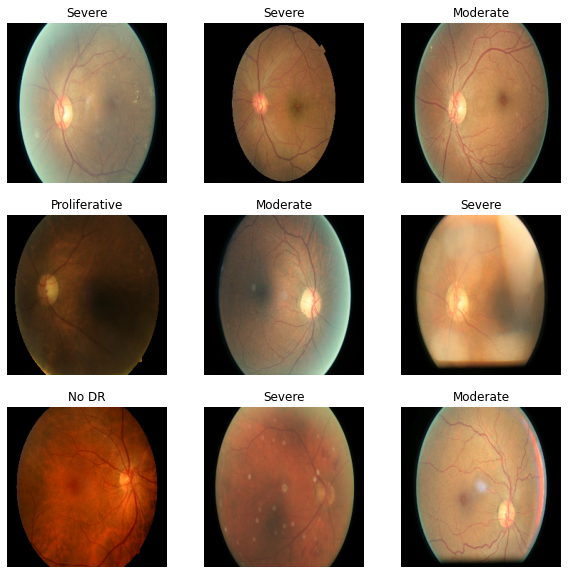

In [7]:
CLASSES=['No DR', 'Mild','Moderate','Severe','Proliferative']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("float"))
    plt.title(CLASSES[labels[i]])
    plt.axis("off")

In [6]:
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda ,BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50

In [7]:
num_classes = 5
input_size = (img_width, img_height, 3) 



in_lay = Input(input_size)
base_pretrained_model = ResNet50(input_shape =  input_size, include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = True
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
pt_features = base_pretrained_model(in_lay)
bn_features = BatchNormalization()(pt_features)
attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1,  kernel_size = (1,1), padding = 'valid', activation = 'sigmoid')(attn_layer)
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = True
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(num_classes, activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', 'accuracy'])
retina_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 2048)  8192        ['resnet50[1][0]']               
 alization)                                                                                       
                             

In [8]:
from tensorflow.keras import callbacks 
save_checkpoint= callbacks.ModelCheckpoint(
                      filepath="/content/drive/MyDrive/", 
                      save_freq='epoch', verbose=1,save_weights_only=True,save_best_only= True)

In [10]:
# learning_rate = 0.0001
# optimizer = tf.keras.optimizers.Adam(learning_rate) # define our optimizer

retina_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['categorical_accuracy', 'accuracy'])


history = retina_model.fit(
        train_ds,
        validation_data = valid_ds,
        epochs = 20, 
        shuffle=True,
        callbacks=save_checkpoint
)

Epoch 1/20
84/84 [==============================] - ETA: 0s - loss: 1.4554 - categorical_accuracy: 0.2392 - accuracy: 0.3292
Epoch 1: val_loss improved from inf to 1.77839, saving model to /content/drive/MyDrive/
84/84 [==============================] - 328s 4s/step - loss: 1.4554 - categorical_accuracy: 0.2392 - accuracy: 0.3292 - val_loss: 1.7784 - val_categorical_accuracy: 0.0000e+00 - val_accuracy: 0.1964
Epoch 2/20
84/84 [==============================] - ETA: 0s - loss: 1.3685 - categorical_accuracy: 0.1979 - accuracy: 0.3828
Epoch 2: val_loss did not improve from 1.77839
84/84 [==============================] - 118s 1s/step - loss: 1.3685 - categorical_accuracy: 0.1979 - accuracy: 0.3828 - val_loss: 4.4919 - val_categorical_accuracy: 0.0000e+00 - val_accuracy: 0.1964
Epoch 3/20
84/84 [==============================] - ETA: 0s - loss: 1.3090 - categorical_accuracy: 0.2243 - accuracy: 0.4107
Epoch 3: val_loss did not improve from 1.77839
84/84 [==============================] - 11

dict_keys(['loss', 'categorical_accuracy', 'accuracy', 'val_loss', 'val_categorical_accuracy', 'val_accuracy'])


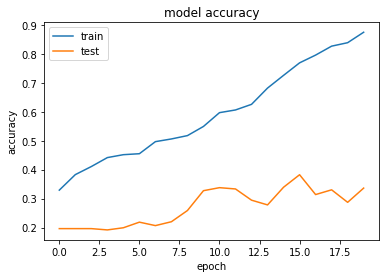

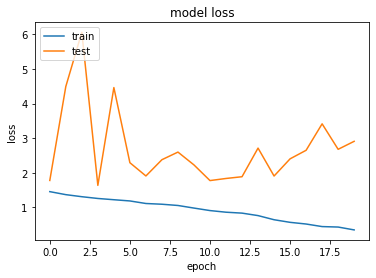

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# load the best version of the model
# retina_model.load_weights()
retina_model.save_weights('/content/drive/MyDrive/Mn3n3_retina_model')

In [12]:
retina_model.evaluate(valid_ds)

21/21 [==============================] - 22s 664ms/step - loss: 2.9084 - categorical_accuracy: 0.3839 - accuracy: 0.3363


[2.9083919525146484, 0.3839285671710968, 0.3363095223903656]

In [14]:
predictions = retina_model.predict(valid_ds)

21/21 [==============================] - 22s 613ms/step


Text(0.5, 15.0, 'Actual')

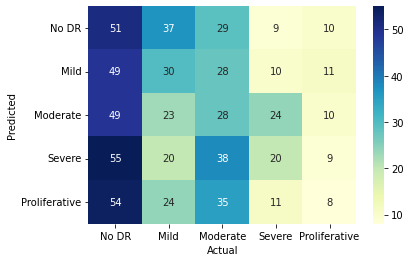

In [20]:
true_categories = tf.concat([y for x, y in valid_ds], axis=0)
cm = confusion_matrix(
    true_categories,
    predictions.argmax(1),
)
df_cm = pd.DataFrame(cm, index=['No DR', 'Mild','Moderate','Severe','Proliferative'], columns=['No DR', 'Mild','Moderate','Severe','Proliferative'])
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")